#Environment Setup

Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# This is to enable GPU
!pip install d2l
!pip install --upgrade mxnet-cu101

!pip install gluonnlp

Mounted at /content/drive
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 356.7MB 47kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 21.0MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595686 sha256=4a700607321e2e513c90c259ef3ff4fbc0580b3f85746eae58a9f05ff918044c
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp


##See which GPU you are allocated.

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


import libraries

In [ ]:
from google.colab import drive
import os
import sys
import warnings
import math
import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
import gluonnlp as nlp
from gluonnlp.calibration import BertLayerCollector
from bert import data
import time
import datetime

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')
sys.path.append("/content/drive/MyDrive/sentence_embedding")
sys.path.append("/content/drive/MyDrive/sentence_embedding/x-final/")
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Helper Functions

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Set Seeds

In [ ]:
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

##Set context to CPU or GPU

In [ ]:
ctx = mx.gpu(0)

#Load BERT

Load Pre-trained model

In [ ]:
bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                            dataset_name='wiki_multilingual_uncased',
                                            pretrained=True, ctx=ctx,
                                            use_pooler=True, use_decoder=False,
                                            use_classifier=False)

print(bert_base)

Vocab file is not found. Downloading.
BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): DotProductSelfAttentionCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): PositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      )
      (1): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (at

## Build the Classifier-on-Top
*   Build classifier on top of BERT
*   Define loss function
*   Define Metrics





In [ ]:
bert_classifier = nlp.model.BERTClassifier(bert_base,
                                           num_classes=2, dropout=0.1)
bert_classifier.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
bert_classifier.hybridize(static_alloc=True)

# softmax cross entropy Loss for classification
loss_function = mx.gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

metric = mx.metric.Accuracy()
val_metric = mx.metric.Accuracy()
test_metric = mx.metric.Accuracy()

#Load Dataset

Take a look at the dataset

In [ ]:
tsv_file = io.open("x-final/en/train.tsv", encoding='utf-8')
for i in range(5):
    print(tsv_file.readline())

id	sentence1	sentence2	label

1	In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .	In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .	0

2	The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .	The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .	1

3	There are also specific discussions , public profile debates and project discussions .	There are also public discussions , profile specific discussions , and project discussions .	0

4	When comparable rates of flow can be maintained , the results are high .	The results are high when comparable flow rates can be maintained .	1



Load train and dev dataset using TSVDataset API

In [ ]:
num_discard_samples = 1
field_separator = nlp.data.Splitter('\t')
field_indices = [1,2,3]

data_train_raw = nlp.data.TSVDataset(filename="x-final/en/train.tsv",
                                     field_separator=field_separator,
                                     num_discard_samples=num_discard_samples,
                                     field_indices=field_indices)

num_discard_samples = 1

data_val_raw = nlp.data.TSVDataset(filename="x-final/en/dev_2k.tsv",
                                     field_separator=field_separator,
                                     num_discard_samples=num_discard_samples,
                                     field_indices=field_indices)


Take a look at some data samples

In [ ]:
for sample_id in range(0):
    #Sentence 1
    print(data_train_raw[sample_id][0])

    #Sentence 2
    print(data_train_raw[sample_id][1])

    #Label
    print(data_train_raw[sample_id][2])

Tokenize Train and Dev Dataset

In [ ]:
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
max_len = 128
all_labels = ["0","1"]
pair=True
transform = data.transform.BERTDatasetTransform(bert_tokenizer, max_len,
                                                class_labels=all_labels,
                                                has_label=True,
                                                pair=pair)
data_train = data_train_raw.transform(transform)
data_val = data_val_raw.transform(transform)

Take a look at the transformed dataset

In [ ]:
sample_id = 0
print("For TRAIN SET:")
print(f'vocabulary used for tokenization = {vocabulary}')
print(f'{vocabulary.padding_token} token id = {vocabulary[vocabulary.padding_token]}')
print(f'{vocabulary.cls_token} token id = {vocabulary[vocabulary.cls_token]}')
print(f'{vocabulary.sep_token} token id = {vocabulary[vocabulary.sep_token]}')
print(f'token ids = {data_train[sample_id][0]}')
print('segment ids = \n%s'%data_train[sample_id][1])
print('valid length = \n%s'%data_train[sample_id][2])
print('label = \n%s'%data_train[sample_id][3])

data_val = data_val_raw.transform(transform)
print("For DEV SET")
print(f'token ids = {data_val[sample_id][0]}')
print('segment ids = \n%s'%data_val[sample_id][1])
print('valid length = \n%s'%data_val[sample_id][2])
print('label = \n%s'%data_val[sample_id][3])


For TRAIN SET:
vocabulary used for tokenization = Vocab(size=105879, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = [    2 10104 10718   117 10104 11411 36810   117 10191 15542 10563 10456
 10103 11807 33345   117 15060 29263 40721 32446 11272   117 63181 11060
 10139   143 91908 10114 14142 10114 11915 11284 17085   119     3 10104
 11411 36810   117 10191 15542 10563 10456 10171 10103 11807 33345   117
 15060 29263 40721 32446 11272   117 10104 10718   117 10110 21675 11060
 10139   143 91908 10114 14142 10114 17085 11284 11915   119     3     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
segment ids = 
[0 0

#Put datasets in Dataloaders

In [ ]:
batch_size = 32
lr = 1e-5
train_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_train],
                                            batch_size=batch_size,
                                            shuffle=True)
train_dataloader = mx.gluon.data.DataLoader(data_train, batch_sampler=train_sampler)

dev_batch_size=16
dev_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_val],
                                            batch_size=dev_batch_size,
                                            shuffle=True)

dev_dataloader = mx.gluon.data.DataLoader(data_val, batch_sampler=dev_sampler)

#TRAINING LOOP

In [ ]:
trainer = mx.gluon.Trainer(bert_classifier.collect_params(), 'adam',
                           {'learning_rate': lr, 'epsilon': 1e-9})
params = [p for p in bert_classifier.collect_params().values() if p.grad_req !='null']
grad_clip = 1
reg_lambda = 5

#For visualizing:
training_stats = []

#Recording time before training starts
t_train_0 = time.time()

log_interval = 8
num_epochs = 4
print("Training...")
for epoch_id in range(num_epochs):
    t_train_epoch_0 = time.time()
    metric.reset()
    step_loss = 0
    train_acc = 0
    print(f'======================================')
    count = 0
    for batch_id, (token_ids, segment_ids, valid_length, label) in enumerate(train_dataloader):
        #=============
        # For A BATCH OF TRAINING DATA
        # ============
        with mx.autograd.record():
            #Autograd is monitoring all the computations here.
            #It's gonna allocate some memory for derivatives
            #It's going to figure out derivatives.
            #Not gonna compute the actual gradient here.

            #Push to the GPU
            token_ids = token_ids.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            label = label.as_in_context(ctx)

            #FORWARD COMPUTATION
            out = bert_classifier(token_ids, segment_ids, valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

        #BACKWARD COMPUTATION
        ls.backward()
        step_loss += ls.asscalar()

        #Gradient Clipping
        #To mitigate the problem of exploding gradients, we 'clip' ie
        #reduce down the gradients
        trainer.allreduce_grads()
        nlp.utils.clip_grad_global_norm(params, 1)
        trainer.update(1)


        metric.update([label], [out])
        train_acc += metric.get()[1]
        count = count + 1

        #PRINTING vital information
        if (batch_id) % (log_interval) == 0:
          print(f'Batch {batch_id+1}/{len(train_dataloader)}], acc={metric.get()[1]:.5f}')
          #loss={step_loss/log_interval:.4f} lr ={trainer.learning_rate: .6f}
            
    avg_step_loss = step_loss/len(train_dataloader)
    
    step_loss_dev = 0
    val_acc = 0
    val_metric.reset()

    for batch_id_dev, (token_ids, segment_ids, valid_length, label) in enumerate(dev_dataloader):
      with mx.autograd.predict_mode():
          #Push to GPU
          token_ids = token_ids.as_in_context(ctx)
          segment_ids = segment_ids.as_in_context(ctx)
          valid_length = valid_length.as_in_context(ctx)
          label = label.as_in_context(ctx)

          out = bert_classifier(token_ids, segment_ids, valid_length.astype('float32'))
          ls_val = loss_function(out, label).mean()

          step_loss_dev += ls_val.asscalar()
          
          val_metric.update([label], [out])
          val_acc += val_metric.get()[1]

          # #Printing vital information
          # if (batch_id_dev) % (log_interval)==0:
          #   print(f'Batch {batch_id_dev + 1}/{len(dev_dataloader)}] val_loss={step_loss_dev / log_interval:.4f} lr ={trainer.learning_rate: .6f}, val_acc={val_metric.get()[1]:.5f}')
          #   step_loss_dev=0
            
    avg_dev_loss = step_loss_dev / len(dev_dataloader)
    epoch_time = format_time(time.time() - t_train_epoch_0)
    #PRINTING VITAL INFORMATION
    # print(f'Epoch {epoch_id+1} train_loss={ls.asscalar():.4f} train_acc={metric.get()[1]:.5f} val_acc={val_metric.get()[1]:.5f} Time Taken={epoch_time}')
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_id + 1,
            'Training Loss': avg_step_loss,
            'Training Acc': train_acc / len(train_dataloader),
            'Valid. Loss': avg_dev_loss,
            'Valid. Accur.': val_acc / len(dev_dataloader),
            'Training Time': epoch_time
        }
    )

    # dd/mm/YY H:M:S
    df = pd.DataFrame(training_stats)
    print(df)
    now = datetime.datetime.now()
    dt_string = now.strftime("%d_%m_%nY_%H:%M")
    #bert_classifier.save_parameters(f"bert_classifier_lenDS-{len(data_train_raw)}_time-{dt_string}_epoch-{epoch_id+1}_en_train_PAWSX_params_only")
    



total_training_time = format_time(time.time() - t_train_0)
print (f'Total Training Took {total_training_time}')


Training...
Batch 1/1549], acc=0.43750
Batch 9/1549], acc=0.44097
Batch 17/1549], acc=0.47978
Batch 25/1549], acc=0.50375
Batch 33/1549], acc=0.51610
Batch 41/1549], acc=0.53277
Batch 49/1549], acc=0.54018
Batch 57/1549], acc=0.54660
Batch 65/1549], acc=0.54471
Batch 73/1549], acc=0.54452
Batch 81/1549], acc=0.54552
Batch 89/1549], acc=0.54775
Batch 97/1549], acc=0.54768
Batch 105/1549], acc=0.54613
Batch 113/1549], acc=0.54812
Batch 121/1549], acc=0.55165
Batch 129/1549], acc=0.55862
Batch 137/1549], acc=0.56204
Batch 145/1549], acc=0.56573
Batch 153/1549], acc=0.56863
Batch 161/1549], acc=0.57279
Batch 169/1549], acc=0.57507
Batch 177/1549], acc=0.57715
Batch 185/1549], acc=0.57753
Batch 193/1549], acc=0.57983
Batch 201/1549], acc=0.58085
Batch 209/1549], acc=0.58373
Batch 217/1549], acc=0.58698
Batch 225/1549], acc=0.58917
Batch 233/1549], acc=0.59134
Batch 241/1549], acc=0.59362
Batch 249/1549], acc=0.59613
Batch 257/1549], acc=0.60044
Batch 265/1549], acc=0.60307
Batch 273/1549], 

In [ ]:
df = pd.DataFrame(training_stats)
df.to_csv("training_stats_lenDS-{len(data_train_raw)}_time-{dt_string}_epoch-{epoch_id+1}_en_train_PAWSX_params_only.csv")
bert_classifier.save_parameters(f"bert_classifier_lenDS-{len(data_train_raw)}_time-{dt_string}_epoch-{epoch_id+1}_en_train_PAWSX_params_only")

#Plot Loss

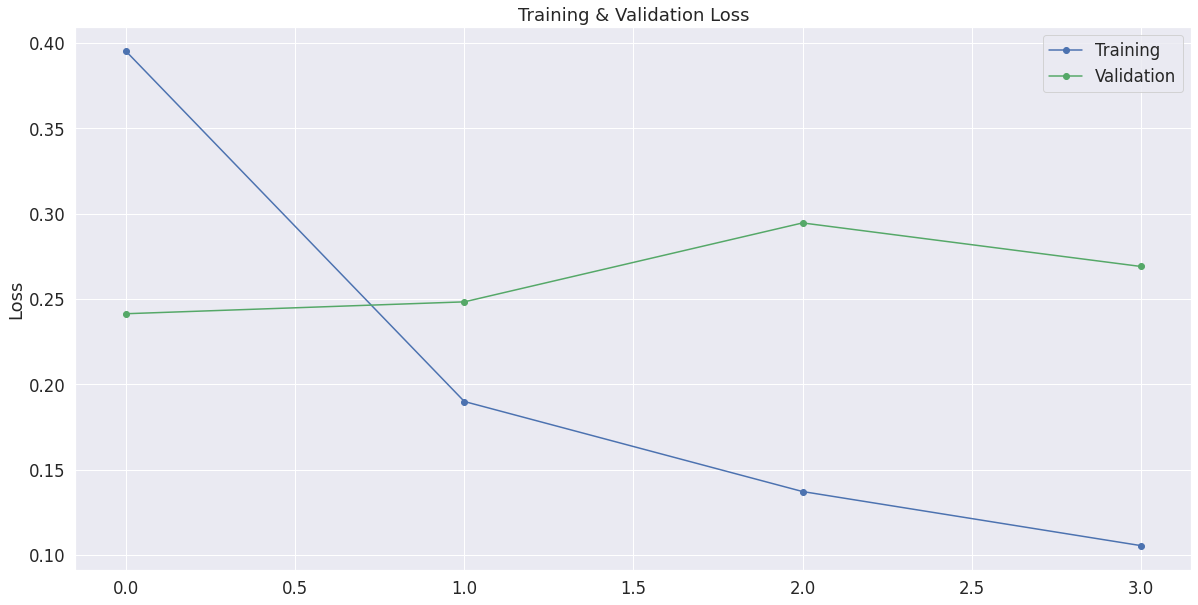

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
plt.plot(df['Training Loss'], 'b-o', label="Training")
plt.plot(df['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Loading the Best Model

In [ ]:
del bert_base
del bert_classifier
del vocabulary

In [ ]:
#SETTING CPU or GPU
ctx = mx.gpu(0)

# """###Load Parameters"""

bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                             dataset_name='wiki_multilingual_uncased',
                                             pretrained=True, ctx=ctx, use_pooler=True,
                                             use_decoder=False, use_classifier=False)

#Build the model for sentence pair classification
bert_classifier = nlp.model.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
# only need to initialize the classifier layer.
bert_classifier.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
bert_classifier.hybridize(static_alloc=True)

# softmax cross entropy loss for classification
loss_function = mx.gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

test_metric = mx.metric.Accuracy()

bert_classifier.load_parameters('/content/drive/MyDrive/bert_classifier_lenDS-49401_time-31_03_2021_22:50_epoch-5_en_train_PAWSX_params_only')

#Evaluating on Other Languages

In [ ]:
def eval_on_test_set(filename='x-final/en/test_2k.tsv', test_batch_size=16):
    # Load the test set
    num_discard_samples_test = 1
    field_separator_test = nlp.data.Splitter('\t')
    field_indices_test = [1, 2, 3]

    # ===================
    # Insert TEST DATASET BELOW
    # ===================
    data_test_raw = nlp.data.TSVDataset(filename=filename,
                                        field_separator=field_separator_test,
                                        num_discard_samples=num_discard_samples_test,
                                        field_indices=field_indices_test)
    sample_id_test = 0
    print("Printing TEST Dataset Sample")
    # Sentence 1
    print(data_test_raw[sample_id_test][0])

    # Sentence 2
    print(data_test_raw[sample_id_test][1])

    # Label
    print(data_test_raw[sample_id_test][2])

    # Transform the test set
    #TOKENIZATION
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)

    max_len = 128

    all_labels = ["0","1"]

    pair=True
    transform = data.transform.BERTDatasetTransform(bert_tokenizer, max_len,
                                                    class_labels=all_labels,
                                                    has_label=True,
                                                    pair=pair)
    data_test = data_test_raw.transform(transform)


    # Create a dataloader
    test_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_test],
                                               batch_size=test_batch_size,
                                               shuffle=True)

    test_dataloader = mx.gluon.data.DataLoader(data_test, batch_sampler=test_sampler)

    # Find and print accuracy on test set

    for batch_id_test, (token_ids, segment_ids, valid_length, label) in enumerate(test_dataloader):
      with mx.autograd.predict_mode():
          token_ids = token_ids.as_in_context(ctx)
          segment_ids = segment_ids.as_in_context(ctx)
          valid_length = valid_length.as_in_context(ctx)
          label = label.as_in_context(ctx)

          out_test = bert_classifier(token_ids, segment_ids, valid_length.astype('float32'))
          loss_test = loss_function(out_test, label).mean()
          test_metric.update([label], [out_test])

    print(f"TEST SET ACCURACY: {test_metric.get()[1]*100} ")
    return test_metric.get()[1]*100


stats = {}
for lang in ['en', 'de', 'es', 'fr', 'ja', 'ko', 'zh']:
  print(f"Evaluating on {lang}")
  filename='x-final/' + lang + '/test_2k.tsv'
  acc = eval_on_test_set(filename=filename)
  stats[lang] = acc

Evaluating on en
Printing TEST Dataset Sample
The exception was between late 2005 and 2009 when he played in Sweden with Carlstad United BK , Serbia with FK Borac Čačak and Russian FC Terek Grozny .
The exception was between late 2005 and 2009 , when he played in Sweden with Carlstad United BK , Serbia with FK Borac Čačak and the Russian FC Terek Grozny .
1
TEST SET ACCURACY: 93.7 
Evaluating on de
Printing TEST Dataset Sample
Die Ausnahme war zwischen Ende 2005 und 2009, als er in Schweden mit Carlstad United BK,  in Serbien mit FK Borac Čačak und dem russischen FC Terek Grozny spielte.
Die Ausnahme war zwischen Ende 2005 und 2009, als er in Schweden mit Carlstad United BK, Serbien mit FK Borac Čačak und dem russischen FC Terek Grozny spielte.
1
TEST SET ACCURACY: 89.67500000000001 
Evaluating on es
Printing TEST Dataset Sample
La excepción fue entre fines de 2005 y 2009 cuando jugó en Suecia con Carlstad United BK, Serbia con FK Borac Čačak y el FC Terek Grozny de Rusia.
La excepción

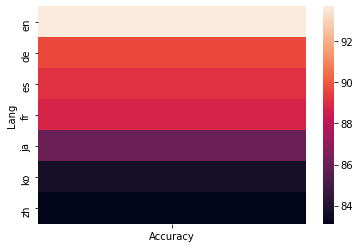

In [19]:
stats_df = pd.DataFrame(list(stats.items()),columns = ['Lang', 'Accuracy']).set_index('Lang')
sns.heatmap(stats_df)
# plt.imshow(stats_df, cmap ="BuGn")
# plt.colorbar()
# plt.xticks(range(0), stats_df.columns)
# plt.yticks(range(len(stats_df)), stats_df.index)
# plt.show()
